<a href="https://colab.research.google.com/github/giakomorssi/Deloitte_Project/blob/main/02_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

from sklearn.metrics import mean_squared_error

import pandas as pd

# Change Colab runtime to GPU
import os
os.environ['COLAB_TPU_ADDR'] = ''
os.environ['COLAB_GPU_ALLOC'] = '1'
os.environ['COLAB_GPU'] = '1'
print("Runtime switched to GPU")

import tensorflow as tf

if not tf.test.gpu_device_name():
    print('GPU device not found')
else:
    print('GPU device found:', tf.test.gpu_device_name())

# This code sets the runtime to use the GPU if available
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

pd.set_option('display.max_columns', None)

!pip install -q category_encoders

Mounted at /content/drive
Runtime switched to GPU
GPU device found: /device:GPU:0
Default GPU Device: /device:GPU:0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 kB 3.5 MB/s eta 0:00:00


In [2]:
df = pd.read_csv('/content/drive/MyDrive/University/Deloitte/SupplyChainDataset.csv', encoding = 'latin-1')

# Old System

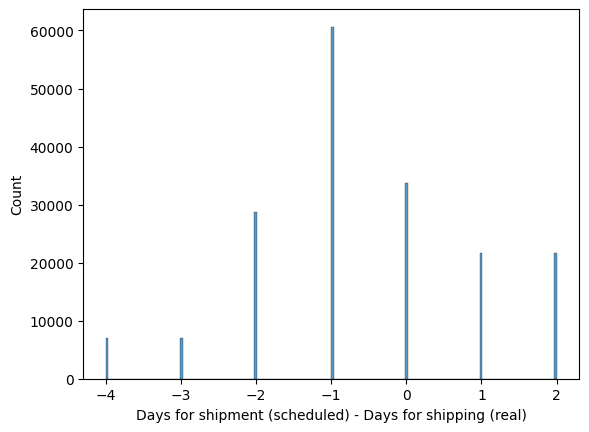

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.histplot(df['Days for shipment (scheduled)'] - df['Days for shipping (real)'])
plt.xlabel('Days for shipment (scheduled) - Days for shipping (real)')
plt.ylabel('Count')
plt.show()

# Cleaning the Data

In [4]:
# Remove Na and Empty Columns

df.drop(['Product Description', 'Order Zipcode', 'Order Profit Per Order', 'Customer Email', 'Customer Password', 'Customer Country', 'Customer Id', 'Customer Fname', 'Customer Lname', 'Customer Street', 'Order Country', 'Product Card Id', 'Product Category Id', 'Product Image', 'Customer State'], axis = 1, inplace = True) 
df.drop('Delivery Status', axis = 1, inplace = True)
df.dropna(inplace = True) #remove 1 missing value

In [5]:
df.head(1)

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Late_delivery_risk,Category Id,Category Name,Customer City,Customer Segment,Customer Zipcode,Department Id,Department Name,Latitude,Longitude,Market,Order City,Order Customer Id,order date (DateOrders),Order Id,Order Item Cardprod Id,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Region,Order State,Order Status,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.25,314.640015,0,73,Sporting Goods,Caguas,Consumer,725.0,2,Fitness,18.251453,-66.037056,Pacific Asia,Bekasi,20755,1/31/2018 22:56,77202,1360,13.11,0.04,180517,327.75,0.29,1,327.75,314.640015,Southeast Asia,Java Occidental,COMPLETE,Smart watch,327.75,0,2/3/2018 22:56,Standard Class


In [6]:
from datetime import datetime

df['order date'] = pd.to_datetime(df['order date (DateOrders)'])
df['shipping date'] = pd.to_datetime(df['shipping date (DateOrders)'])

df['order date'] = df['order date'].apply(lambda x: x.timestamp())
df['shipping date'] = df['shipping date'].apply(lambda x: x.timestamp())

df.drop(['order date (DateOrders)', 'shipping date (DateOrders)'], axis = 1, inplace = True)

In [23]:
df.to_csv('/content/drive/MyDrive/University/Deloitte/SupplyChainDataset_prediction.csv', index = False)

# Encoding

### Label Encoding

In [24]:
df = pd.read_csv('/content/drive/MyDrive/University/Deloitte/SupplyChainDataset_prediction.csv')

In [25]:
from sklearn.model_selection import train_test_split

X = df.drop(['Days for shipping (real)', 'Product Name', 'Days for shipment (scheduled)'], axis = 1)
#X = df.drop('Late_delivery_risk', axis = 1)
y = df['Days for shipping (real)']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [27]:
import pandas as pd
from category_encoders import LeaveOneOutEncoder

# initialize the encoder
enc = LeaveOneOutEncoder(cols=['Customer City', 'Order City', 'Order State', 'Order Region'])

# fit and transform the entire dataset
X_train = enc.fit_transform(X_train, y_train)
X_test = enc.transform(X_test)

In [28]:
X_train.head(1)

,Type,Benefit per order,Sales per customer,Late_delivery_risk,Category Id,Category Name,Customer City,Customer Segment,Customer Zipcode,Department Id,Department Name,Latitude,Longitude,Market,Order City,Order Customer Id,Order Id,Order Item Cardprod Id,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Region,Order State,Order Status,Product Price,Product Status,Shipping Mode,order date,shipping date
169535,TRANSFER,13.49,41.5,1,24,Women's Apparel,3.40535,Home Office,10023.0,5,Golf,40.618786,-73.999023,USCA,3.166667,8785,33868,502,8.5,0.17,84549,50.0,0.33,1,50.0,41.5,3.484193,3.538226,PENDING,50.0,0,Second Class,1.462785e+09,1.463130e+09


In [29]:
from sklearn.preprocessing import OneHotEncoder

# Select columns for one-hot encoding
#one_hot_cols = [0, 6, 8, 11, 14, 29]
one_hot_cols = [0, 5, 7, 10, 13, 28] #use this if we want to remove Late_delivery_risk

# Type, Department Name, Category Name, Market, Order Status, Customer Segment

# Fit one-hot encoder to training data
one_hot_encoder = OneHotEncoder(handle_unknown="ignore")

# Apply one-hot encoder to training and test data
X_train_one_hot = one_hot_encoder.fit_transform(X_train.iloc[:, one_hot_cols])
X_test_one_hot = one_hot_encoder.transform(X_test.iloc[:, one_hot_cols])

# Remove original columns from training and test data
X_train = X_train.drop(X_train.columns[one_hot_cols], axis=1)
X_test = X_test.drop(X_test.columns[one_hot_cols], axis=1)

# Concatenate one-hot encoded columns with remaining data
X_train = pd.concat([pd.DataFrame(X_train_one_hot.toarray()), X_train.reset_index(drop=True)], axis=1)
X_test = pd.concat([pd.DataFrame(X_test_one_hot.toarray()), X_test.reset_index(drop=True)], axis=1)

In [30]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

# Shipping Mode
custom_order = ['Same Day', 'First Class', 'Second Class', 'Standard Class']
le.fit(custom_order)
X_train['Shipping Mode'] = le.fit_transform(X_train['Shipping Mode'])
X_test['Shipping Mode'] = le.transform(X_test['Shipping Mode'])

## Scale the Data

In [31]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train.iloc[:, 82:] = scaler.fit_transform(X_train.iloc[:, 82:])
X_test.iloc[:, 82:] = scaler.transform(X_test.iloc[:, 82:])

<ipython-input-31-6700864cfc85>:5: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X_train.iloc[:, 82:] = scaler.fit_transform(X_train.iloc[:, 82:])
<ipython-input-31-6700864cfc85>:6: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X_test.iloc[:, 82:] = scaler.transform(X_test.iloc[:, 82:])


In [32]:
import pandas as pd
import numpy as np
import pickle

# Split the dataset into features and target
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
y_train = pd.DataFrame(y_train)
y_train = np.ravel(y_train)

X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

In [33]:
X_train.shape

(144412, 110)

# Prediction

## Choosing the Model

In [21]:
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import Ridge

model = VotingRegressor([('brr', BayesianRidge()), ('ridge', Ridge())], weights=[2, 1])

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

with open('/content/drive/MyDrive/University/Deloitte/models_lr/voting1.pkl', 'wb') as f:
  pickle.dump(model, f)

print('rMSE', mean_squared_error(y_test, y_pred, squared=False))

rMSE 0.18973559042504684


In [22]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

model = StackingRegressor(estimators=[('brr', BayesianRidge()), ('ridge', Ridge())], final_estimator=DecisionTreeRegressor())

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

with open('/content/drive/MyDrive/University/Deloitte/models_lr/stacking1.pkl', 'wb') as f:
  pickle.dump(model, f)

print('rMSE', mean_squared_error(y_test, y_pred, squared=False))

rMSE 0.03608039377527565


## try

In [34]:
import pickle

with open('/content/drive/MyDrive/University/Deloitte/models_lr/stacking1.pkl', 'rb') as f:
  model = pickle.load(f)

y_pred = model.predict(X_test)

print('rMSE', mean_squared_error(y_test, y_pred, squared=False))

rMSE 0.035694496115761615


In [35]:
residuals = y_test - y_pred

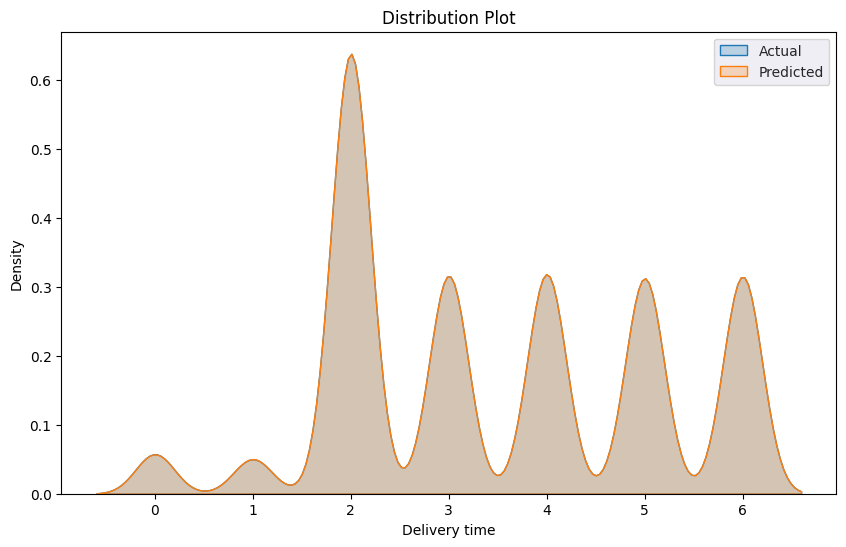

In [36]:
from matplotlib import pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 6))
sns.set_palette('colorblind')
sns.set_style('darkgrid')
sns.kdeplot(y_test.ravel(), label='Actual', fill=True)
sns.kdeplot(y_pred.ravel(), label='Predicted', fill=True)
plt.xlabel('Delivery time')
plt.ylabel('Density')
plt.title('Distribution Plot')
plt.legend()
plt.show()

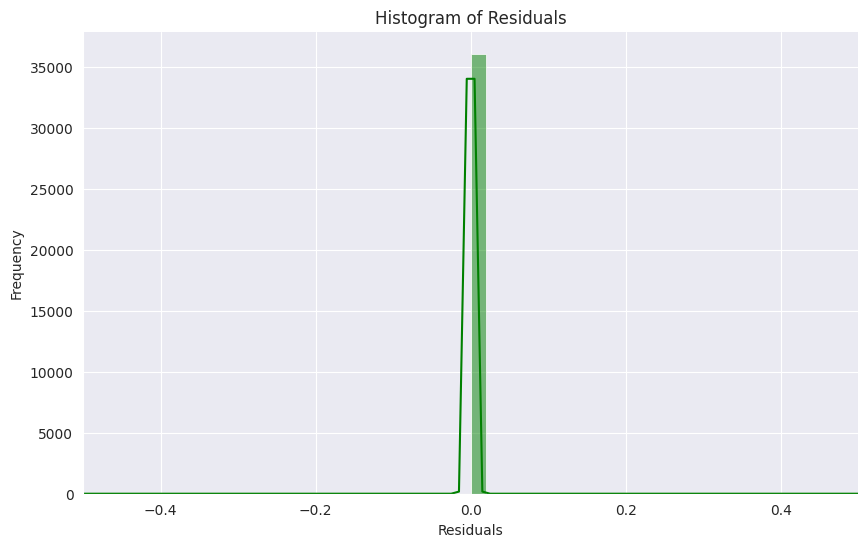

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(residuals, bins=100, color='green', kde=True, ax=ax)
ax.set_xlabel('Residuals')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Residuals')
ax.set_xlim((-0.5, 0.5))
sns.despine()
plt.show()

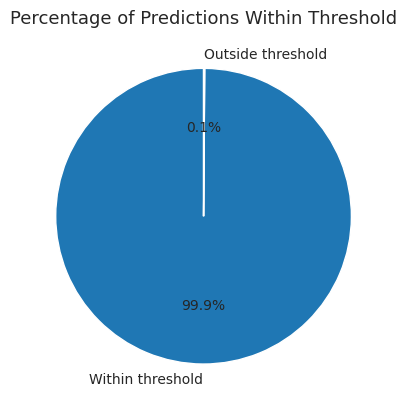

In [ ]:
within_threshold = (np.abs(y_pred.ravel() - y_test.ravel()) < 0.00000000001).mean() #0.1 = 2.4 hours
outside_threshold = 1 - within_threshold
fig, ax = plt.subplots()
labels = ['Within threshold', 'Outside threshold']
sizes = [within_threshold, outside_threshold]
colors = ['#1f77b4', '#ff7f0e']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Percentage of Predictions Within Threshold', fontsize=13)
plt.show()

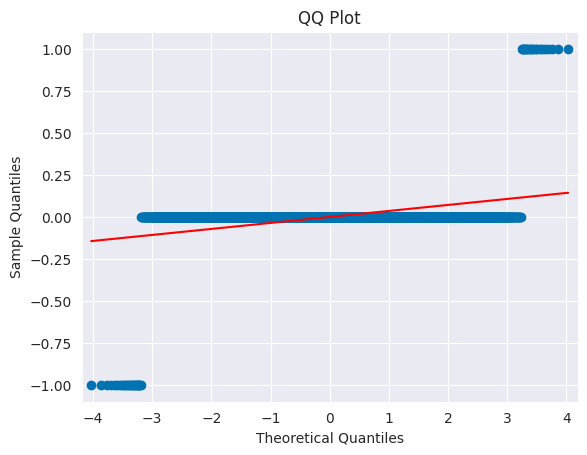

In [ ]:
import statsmodels.api as sm

fig, ax = plt.subplots()
sm.qqplot(residuals, line='s', ax=ax)
ax.set_title('QQ Plot')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.show()

# nn


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from keras.optimizers import SGD
from keras.optimizers import Adagrad

# Define the neural network architecture
model = Sequential()
model.add(Dense(516, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01))) 
#model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
#model.add(Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(1, activation='linear'))

# Compile the model with mean squared error loss function and Adam optimizer
model.compile(loss='mean_squared_error', optimizer=Adagrad(learning_rate=0.01), metrics=['mean_squared_error'])

# Define the early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_mean_squared_error', patience=10, verbose=2, mode='min')
model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/University/Deloitte/models_lr/nn3.h5', monitor='val_mean_squared_error', save_best_only=True, mode='min')

# Fit the model to the training data with early stopping and model checkpoint callbacks
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test), verbose=2, callbacks=[early_stopping, model_checkpoint])

# Evaluate the model on the test data
loss, mse = model.evaluate(X_test, y_test, verbose=0)
print('Mean Squared Error on test set: {:.4f}'.format(mse))

# Plot the training and validation loss over epochs
import matplotlib.pyplot as plt
plt.plot(np.sqrt(history.history['mean_squared_error']), label='training mse')
plt.plot(np.sqrt(history.history['val_mean_squared_error']), label='validation mse')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

loss, mse = model.evaluate(X_test, y_test, verbose=0)

print(f'rMSE :{np.sqrt(mse)}, MSE: {mse}, Loss: {loss}')

Epoch 1/100
2257/2257 - 17s - loss: 3.6431 - mean_squared_error: 0.6343 - val_loss: 1.3558 - val_mean_squared_error: 0.5621 - 17s/epoch - 8ms/step
Epoch 2/100


KeyboardInterrupt: ignored